# Attention Rank Visualizer — per head or whole layer

This notebook is based on the paper [When Attention Collapses: How Degenerate Layers in LLMs Enable Smaller, Stronger Models](https://arxiv.org/html/2404.08634v3).

1. Build the attention matrix `A` for a chosen head from the `CausalSelfAttention` module.
2. Measure an **effective rank**: the smallest `k` whose top singular values explain **90%** of the matrix energy.
3. Measure **single‑column‑ness**: the fewest columns needed to cover **90%** of the squared entries of `A`.
4. Plot a heatmap of `A` and a per‑head rank profile.

**Assumptions**
- Uses `models.gpt2.attention.CausalSelfAttention`'s merged QKVO weights in `qkvo_w` of shape `(4, num_heads*head_dim, dim)`.
- Hidden states `X` of shape `(T, dim)` that enter this attention block (from the previous layer).

**Tip**: Start with short sequences (e.g., `T ≤ 128`) because SVD (Singular Value Decomposition) scales cubically with `T`.


In [ ]:
import math
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from models.gpt2.attention import CausalSelfAttention
torch.set_printoptions(precision=4, sci_mode=True)
device = 'cpu'
CHECKPOINT_PATH = "/Users/jonathanmiddleton/models/checkpoints/350m-instruct/20251011T1549-val2.770-step005000-run1-best.pt"
LAYER_ID = 4


## Build the attention matrix `A`
`A` is computed as a row‑wise softmax of the scaled score matrix. Rows index **query** positions; columns index **key** positions.


In [2]:
def _row_softmax_with_causal_mask(scores: torch.Tensor) -> torch.Tensor:
    """Row‑wise softmax. scores: (H, T, T)."""
    T = scores.shape[-1]
    mask = torch.triu(torch.ones((T, T), dtype=torch.bool, device=scores.device), diagonal=1)
    scores = scores.masked_fill(mask, float('-inf'))
    return F.softmax(scores, dim=-1)

def attention_matrix_from_attn(attn: CausalSelfAttention, X: torch.Tensor) -> torch.Tensor:
    """
    Compute A for a single CausalSelfAttention module with merged QKVO weights.
    - attn.qkvo_w: (4, num_heads*head_dim, dim) with indices 0=Q, 1=K, 2=V, 3=O
    - attn.num_heads, attn.head_dim
    - X: (T, dim) hidden states entering this attention block
    Returns: A of shape (num_heads, T, T)
    """
    assert hasattr(attn, 'qkvo_w'), 'Expected attn.qkvo_w merged weights.'
    H = int(attn.num_heads)
    Dh = int(attn.head_dim)
    T, D = X.shape

    # Extract Q and K weights and compute projected states.
    Wq = attn.qkvo_w[0].to(dtype=torch.float32)  # (H*Dh, D)
    Wk = attn.qkvo_w[1].to(dtype=torch.float32)  # (H*Dh, D)
    Xf = X.to(dtype=torch.float32)
    Q = Xf @ Wq.T  # (T, H*Dh)
    K = Xf @ Wk.T  # (T, H*Dh)

    # Reshape to per‑head tensors: (H, T, Dh)
    Q = Q.view(T, H, Dh).transpose(0, 1).contiguous()
    K = K.view(T, H, Dh).transpose(0, 1).contiguous()

    Q = attn.rotary(Q)
    K = attn.rotary(K)

    # Scores and A: (H, T, T)
    scores = Q @ K.transpose(-1, -2) * attn.attn_scale
    A = _row_softmax_with_causal_mask(scores)[0] # B,H,T,T -> H,T,T
    return A


## Metrics: effective rank (90%) and single‑column mass (90%)
- **effective_rank90(A)**: the smallest `k` so that the top `k` singular values of `A` explain at least 90% of the squared entries.
- **columns90(A)**: the fewest columns needed so that their squared entries sum to at least 90% of the squared entries of `A`.

Both are computed per head. Use small `T` during exploration for speed.


In [3]:
def effective_rank90(A_2d: torch.Tensor) -> int:
    """A_2d: (T, T)."""
    # Use float64 on CPU for numerical stability
    S = torch.linalg.svdvals(A_2d.to(dtype=torch.float64, device=device))  # singular values
    S2 = S**2
    total = float(S2.sum())
    csum = torch.cumsum(S2, dim=0)
    k = int(torch.searchsorted(csum, 0.90 * total).item()) + 1
    return k

def columns90(A_2d: torch.Tensor) -> int:
    """Fewest columns whose squared entries cover 90% of total squared entries."""
    col_mass = (A_2d**2).sum(dim=0)  # (T,)
    vals, _ = torch.sort(col_mass.to(dtype=torch.float64, device=device), descending=True)
    csum = torch.cumsum(vals, dim=0)
    total = float(vals.sum())
    m = int(torch.searchsorted(csum, 0.90 * total).item()) + 1
    return m

def per_head_metrics(A: torch.Tensor):
    """A: (H, T, T). Returns lists: ranks, masses, and their maxima."""
    H = A.shape[0]
    ranks, masses = [], []
    for h in range(H):
        r = effective_rank90(A[h])
        m = columns90(A[h])
        ranks.append(r)
        masses.append(m)
    return ranks, masses, max(ranks) if ranks else None


## Plot helpers
We use plain Matplotlib (no seaborn). Each chart uses its own figure.


In [4]:
def show_attention_heatmap(A: torch.Tensor, head: int=0, title: str=None):
    """A: (H, T, T) or (T, T)."""
    plt.figure()
    if A.dim() == 3:
        M = A[head].detach().cpu().numpy()
    else:
        M = A.detach().cpu().numpy()
    plt.imshow(M, aspect='auto')
    plt.colorbar()
    plt.xlabel('Key position j')
    plt.ylabel('Query position i')
    if title:
        plt.title(title)
    plt.show()

def plot_head_ranks(ranks, title: str='Effective rank (90%) per head'):
    plt.figure()
    xs = list(range(len(ranks)))
    plt.plot(xs, ranks, marker='o')
    plt.xlabel('Head index')
    plt.ylabel('Rank-90%')
    plt.title(title)
    plt.show()

def plot_head_masses(masses, title: str='Fewest columns for 90% mass per head'):
    plt.figure()
    xs = list(range(len(masses)))
    plt.plot(xs, masses, marker='o')
    plt.xlabel('Head index')
    plt.ylabel('#columns for 90% mass')
    plt.title(title)
    plt.show()


Per‑head effective ranks: [4, 2, 1, 2, 2, 2, 2, 5]
Per‑head columns@90%: [4, 2, 1, 2, 2, 2, 2, 5]
MaxRank(layer) = 5


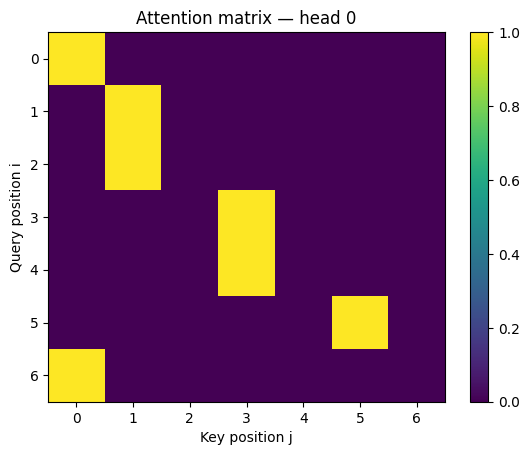

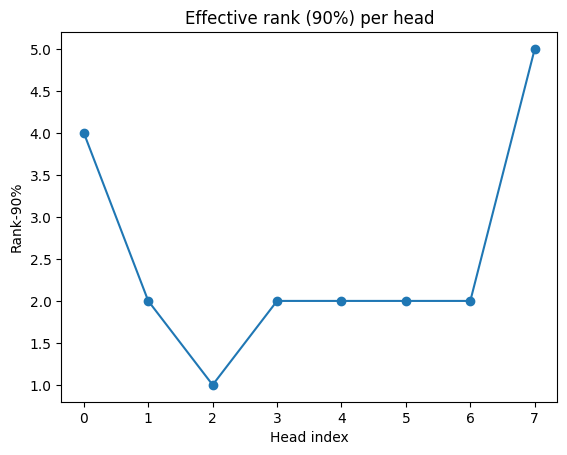

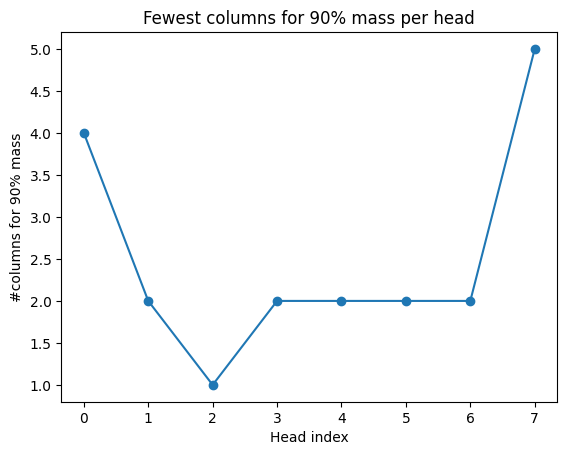

In [5]:
from models import model_from_spec
from models.gpt2.gpt_core import GPT2Core
import tiktoken
model: GPT2Core = model_from_spec('gpt2_350m', device=device).eval()
attn: CausalSelfAttention = model.blocks[0].attn

enc = tiktoken.get_encoding("gpt2")

s = "What is the meaning of life?"
tokens = enc.encode(s, allowed_special={"<|endoftext|>"})
p = torch.tensor(tokens, dtype=torch.long)[None,:]

with torch.no_grad():
    if CHECKPOINT_PATH is not None:
        from tools.checkpoint import load_checkpoint, apply_model_state
        ckpt = load_checkpoint(CHECKPOINT_PATH, map_location=device)
        state_dict = ckpt.model
        apply_model_state(model, state_dict, strict=True)
    model.prefill_batch(p, 256)
    block = model.blocks[LAYER_ID]
    X: torch.Tensor = block.in_t[0] # (T, dim)

    B = 1
    H = int(attn.num_heads)
    Dh = int(attn.head_dim)
    T, D = X.shape

    # Extract Q and K weights and compute projected states.
    Wq = attn.qkvo_w[0].to(dtype=torch.float32)  # (H*Dh, D)
    Wk = attn.qkvo_w[1].to(dtype=torch.float32)  # (H*Dh, D)
    Xf = X.to(dtype=torch.float32)
    Q = Xf @ Wq.T  # (T, H*Dh)
    K = Xf @ Wk.T  # (T, H*Dh)

    # Reshape to per‑head tensors: (B,T,H,Dh)
    # Q = Q.view(B, H, T, Dh).transpose(1, 2).contiguous()
    # K = K.view(B, H, T, Dh).transpose(1, 2).contiguous()
    Q = Q.view(B, T, H, Dh).contiguous()
    K = K.view(B, T, H, Dh).contiguous()

    Q = attn.rotary(Q)
    K = attn.rotary(K)

    # Scores and A: (H, T, T)
    scores = Q @ K.transpose(-1, -2) * attn.attn_scale
    A = _row_softmax_with_causal_mask(scores)

    A = attention_matrix_from_attn(attn, X)
    ranks, masses, max_rank = per_head_metrics(A)
    print('Per‑head effective ranks:', ranks)
    print('Per‑head columns@90%:', masses)
    print('MaxRank(layer) =', max_rank)
    show_attention_heatmap(A, head=0, title='Attention matrix — head 0')
    plot_head_ranks(ranks)
    plot_head_masses(masses)

## Batch over multiple sequences (to average per head)
- Mirror the paper's setup: sample `N=100` sequences with `T=100`, then compute per‑head averages and finally `MaxRank(l)` as the maximum head rank per layer.
- To inspect a **single‑column** pattern directly, sort the columns of `A[h]` by their squared mass and see if the first one dominates.


In [6]:
def average_per_head_over_sequences(attn, X_list) -> dict:
    H = int(attn.num_heads)
    sum_r = torch.zeros(H, dtype=torch.float64, device=device)
    sum_m = torch.zeros(H, dtype=torch.float64, device=device)
    cnt = torch.zeros(H, dtype=torch.int64, device=device)

    for X in X_list:
        A = attention_matrix_from_attn(attn, X)
        for h in range(H):
            r = effective_rank90(A[h])
            m = columns90(A[h])
            sum_r[h] += r
            sum_m[h] += m
            cnt[h] += 1

    avg_r = (sum_r / cnt.clamp_min(1)).tolist()
    avg_m = (sum_m / cnt.clamp_min(1)).tolist()
    return {
        'avg_ranks_per_head': avg_r,
        'avg_columns90_per_head': avg_m,
        'MaxRank_layer': max(avg_r) if len(avg_r) else None
    }


In [7]:
from training.data_gen import DistributedDataGenerator

data_loader = DistributedDataGenerator(
    "../../data/fineweb/fineweb_val_000000.bin",
    1 * 100,
    rank = 0,
    world_size=1,
    device=device,
)
with torch.no_grad():
    I = [inputs[None,:] for inputs, _ in (next(data_loader) for _ in range(100))] # 100 in paper
    Xs = [model.blocks[LAYER_ID].in_t[0] for inputs in I for _ in model.prefill_batch(inputs, 100)]

    avgs = average_per_head_over_sequences(attn, Xs)
    print("avg_ranks_per_head:", avgs["avg_ranks_per_head"])
    print("avg_columns90_per_head", avgs["avg_columns90_per_head"])
    print("MaxRank_layer:", avgs["MaxRank_layer"])

avg_ranks_per_head: [11.62, 4.7, 3.92, 6.35, 5.36, 4.77, 6.42, 6.8]
avg_columns90_per_head [11.53, 4.67, 3.91, 6.32, 5.34, 4.76, 6.38, 6.77]
MaxRank_layer: 11.62
